In [13]:
import pyro
import numpy as np                                                                                                                                                   
import torch
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn import model_selection
import pyro.distributions as pdist
import pyro.contrib.gp as gp
import torch.distributions as tdist
import torch.nn as tnn
import pyro.nn as pnn
import arviz

## B1

In [14]:
def func(X):
    return torch.sin(20*X)+2*torch.cos(14*X)-2*torch.sin(6*X)

In [15]:
# Data
X = torch.tensor([-1, -1/2, 0, 1/2, 1])
y = func(X)

In [16]:
# Define Model
kernel = gp.kernels.RBF(input_dim=1)
kernel.lengthscale = pyro.nn.PyroSample(pdist.LogNormal(-1,1))
kernel.variance = pyro.nn.PyroSample(pdist.LogNormal(0,2))
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1e-4))

In [17]:
# NUTS to sample from posterior
nuts_kernel = pyro.infer.NUTS(gpr.model)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=500, num_chains=2, warmup_steps=5) #tuning for warmup_steps
mcmc.run()

Sample [2]: 100%|██████████| 505/505 [00:15, 33.02it/s, step size=3.32e-01, acc. prob=0.827]


                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.309  0.175   0.026    0.609      0.011    0.008   
kernel.variance     4.622  5.151   0.785   10.655      0.336    0.238   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale     283.0     377.0   1.01  
kernel.variance        290.0     299.0   1.01  


D:\anaconda3\envs\torch_116\lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


array([<AxesSubplot: title={'center': 'kernel.lengthscale'}>,
       <AxesSubplot: title={'center': 'kernel.variance'}>], dtype=object)

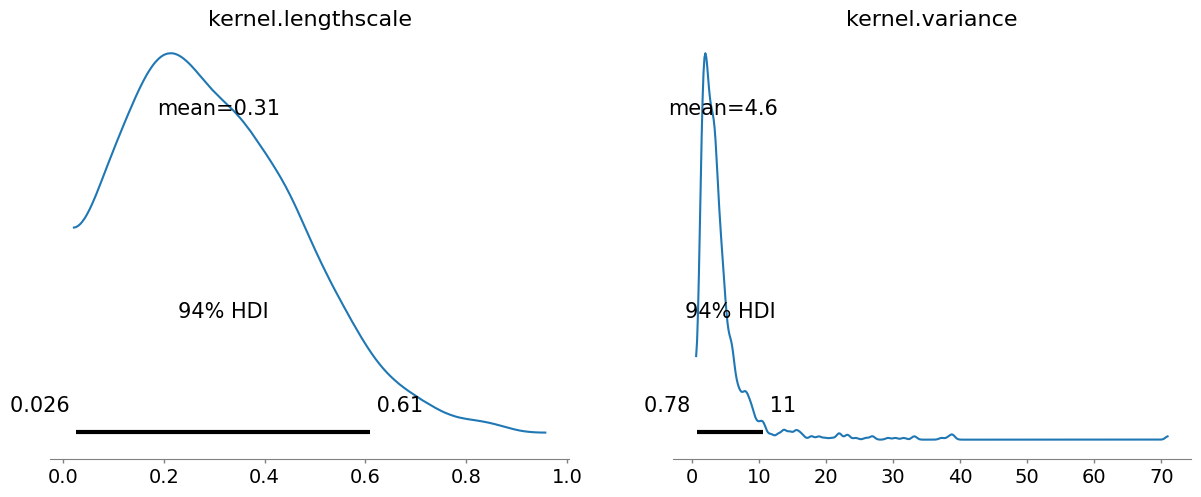

In [18]:
# diagnostics to choose hyperparameters of the sampling
data = arviz.from_pyro(mcmc)
summary = arviz.summary(data)
print(summary)
arviz.plot_posterior(data)

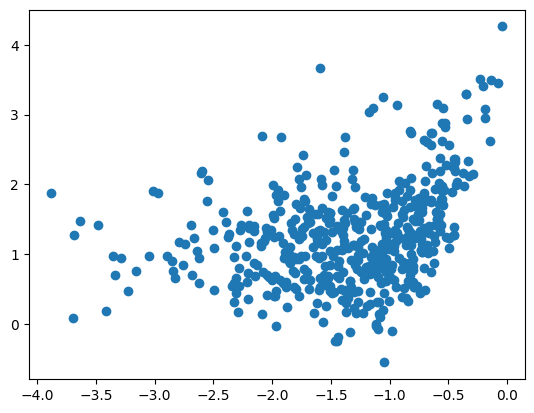

In [19]:
# scattor plot of samples from posterior
ls = mcmc.get_samples()['kernel.lengthscale'][:500]
var = mcmc.get_samples()['kernel.variance'][:500]
plt.scatter(torch.log(ls), torch.log(var))

In [20]:
## estimate new point
Xnew = torch.linspace(-1,1,200)
f_loc, f_cov = gpr(Xnew, full_cov = False)

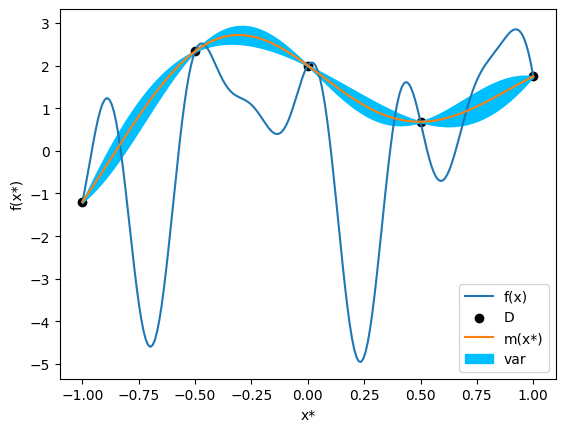

In [21]:
plt.plot(Xnew, func(Xnew),label = 'f(x)')
plt.scatter(X,y,label = 'D',color='black')
plt.plot(Xnew, f_loc.detach().numpy(), label='m(x*)')
plt.fill_between(Xnew, f_loc.detach().numpy()+2*(f_cov.sqrt()).detach().numpy(), f_loc.detach().numpy()-2*(f_cov.sqrt()).detach().numpy(),color="deepskyblue",label='var')
plt.xlabel("x*")
plt.ylabel("f(x*)")
plt.legend()

## B2

In [63]:
# Initial dataset
X = torch.tensor([-1, -1/2, 0, 1/2, 1])
y = func(X)
Xnew = torch.linspace(-1,1,200)
T = 10

def Bayesian_Optimization(X, y, Xnew):
    f_list = []
    f_loc_list = []
    f_cov_list = []
    for k in range(T+1):
        pyro.clear_param_store()
        kernel = gp.kernels.RBF(input_dim=1)
        kernel.variance = pyro.nn.PyroSample(pdist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
        kernel.lengthscale = pyro.nn.PyroSample(pdist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))
        gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1e-4))
        nuts_kernel=pyro.infer.NUTS(gpr.model)
        mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=100, num_chains=2, warmup_steps=5)
        mcmc.run()
        sample = torch.randint(200,(1,))
        kernel.variance = mcmc.get_samples()["kernel.variance"][sample]
        kernel.lengthscale = mcmc.get_samples()["kernel.lengthscale"][sample]
        with torch.no_grad():
            f_loc, f_cov = gpr(Xnew , full_cov=False, noiseless=False)
            f_loc_list.append(f_loc)
            f_cov_list.append(f_cov)
            f = tdist.Normal(f_loc, f_cov).sample()
            f_list.append(f)
            x_p = torch.tensor([Xnew[torch.argmin(f)]])
            X = torch.cat([X, x_p])
            y = torch.cat([y, func(x_p)])
    return X, y, f_loc_list, f_cov_list, f_list

In [64]:
def plot():
    plt.figure(figsize=(18,15))
    counter = 1
    for k in (0,5,10):
        plt.subplot(3,3,counter)
        plt.plot(Xnew, func(Xnew),label = 'f(x)')
        plt.plot(Xnew, f_list[k].detach().numpy(), label='f*')
        plt.fill_between(Xnew, f_loc_list[k].detach().numpy()+2*(f_cov_list[k].sqrt()).detach().numpy(), 
                         f_loc_list[k].detach().numpy()-2*(f_cov_list[k].sqrt()).detach().numpy(),color="aquamarine",label='var')
        plt.scatter(X[5+k],y[5+k],label='added pair',color='black')
        plt.xlabel("x*")
        plt.ylabel("f(x*)")
        plt.legend()
        counter += 1

Sample [2]: 100%|██████████| 105/105 [00:35,  2.95it/s, step size=1.83e-02, acc. prob=0.999]


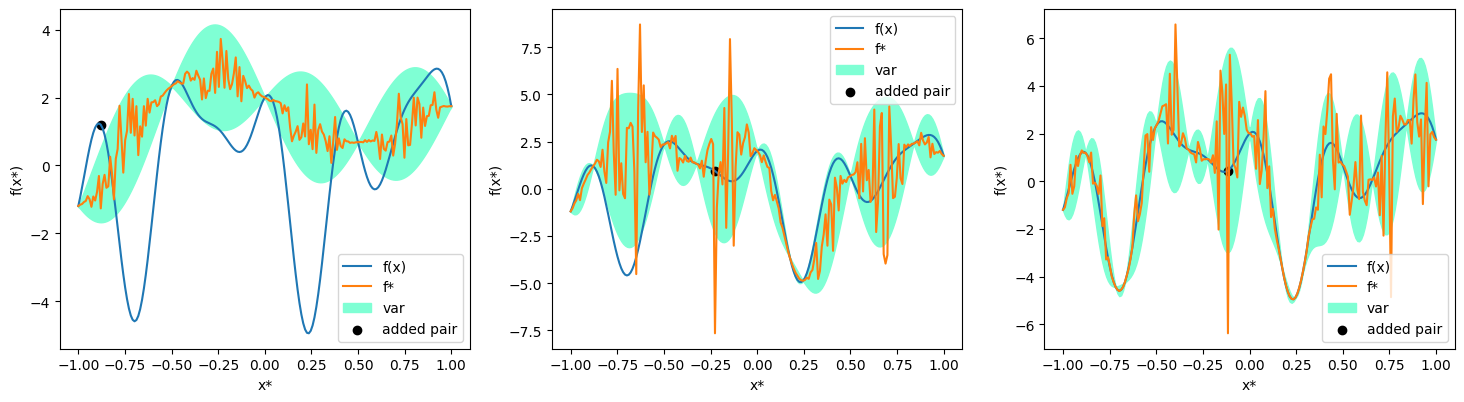

In [65]:
# times = 1
X, y, f_loc_list, f_cov_list, f_list = Bayesian_Optimization(X, y, Xnew)
plot()

Sample [2]: 100%|██████████| 105/105 [00:26,  4.00it/s, step size=2.40e-01, acc. prob=0.717]


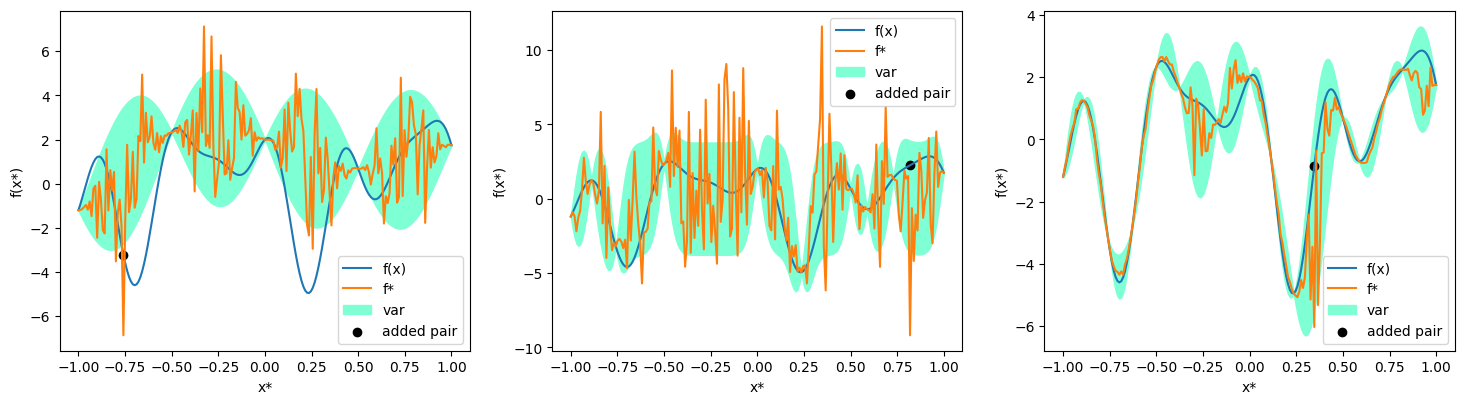

In [67]:
# times = 2
X = torch.tensor([-1, -1/2, 0, 1/2, 1])
y = func(X)
Xnew = torch.linspace(-1,1,200)
X, y, f_loc_list, f_cov_list, f_list = Bayesian_Optimization(X, y, Xnew)
plot()

Sample [2]: 100%|██████████| 105/105 [00:06, 15.48it/s, step size=1.41e-01, acc. prob=0.908]


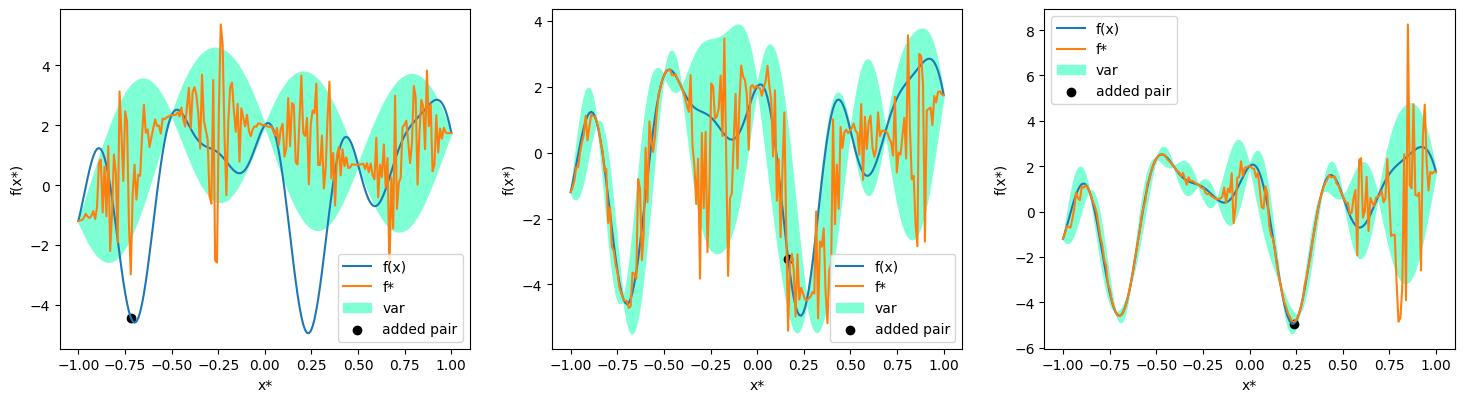

In [68]:
# times = 3
X = torch.tensor([-1, -1/2, 0, 1/2, 1])
y = func(X)
Xnew = torch.linspace(-1,1,200)
X, y, f_loc_list, f_cov_list, f_list = Bayesian_Optimization(X, y, Xnew)
plot()

Conclusion: We tried 3 times of the algorithm, but only once the global optimum be found.

Solution: Instead sampling $f^*$ direactly from the posterior predictive distribution, we can sample $f_var$, and using $f_{mean} - |f_{var}|$ as our $f^*$

In [72]:
def Bayesian_Optimization_modified(X, y, Xnew):
    f_list = []
    f_loc_list = []
    f_cov_list = []
    for k in range(T+1):
        pyro.clear_param_store()
        kernel = gp.kernels.RBF(input_dim=1)
        kernel.variance = pyro.nn.PyroSample(pdist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
        kernel.lengthscale = pyro.nn.PyroSample(pdist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))
        gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1e-4))
        nuts_kernel=pyro.infer.NUTS(gpr.model)
        mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=100, num_chains=2, warmup_steps=5)
        mcmc.run()
        sample = torch.randint(200,(1,))
        kernel.variance = mcmc.get_samples()["kernel.variance"][sample]
        kernel.lengthscale = mcmc.get_samples()["kernel.lengthscale"][sample]
        with torch.no_grad():
            f_loc, f_cov = gpr(Xnew , full_cov=False, noiseless=False)
            f_loc_list.append(f_loc)
            f_cov_list.append(f_cov)
            f = f_loc - abs(tdist.Normal(0,f_cov).sample())# f = tdist.Normal(f_loc, f_cov).sample()
            f_list.append(f)
            x_p = torch.tensor([Xnew[torch.argmin(f)]])
            X = torch.cat([X, x_p])
            y = torch.cat([y, func(x_p)])
    return X, y, f_loc_list, f_cov_list, f_list

Sample [2]: 100%|██████████| 105/105 [02:45,  1.57s/it, step size=6.17e-02, acc. prob=0.973]


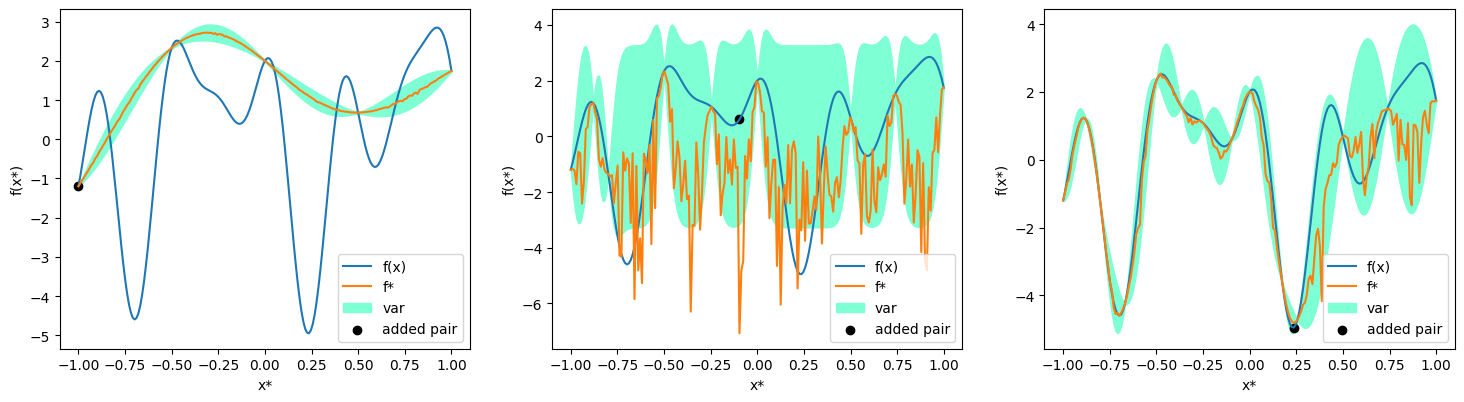

In [73]:
# times = 1
X = torch.tensor([-1, -1/2, 0, 1/2, 1])
y = func(X)
Xnew = torch.linspace(-1,1,200)
T = 10

X, y, f_loc_list, f_cov_list, f_list = Bayesian_Optimization_modified(X, y, Xnew)
plot()

Sample [2]: 100%|██████████| 105/105 [00:37,  2.81it/s, step size=2.76e-01, acc. prob=0.609]


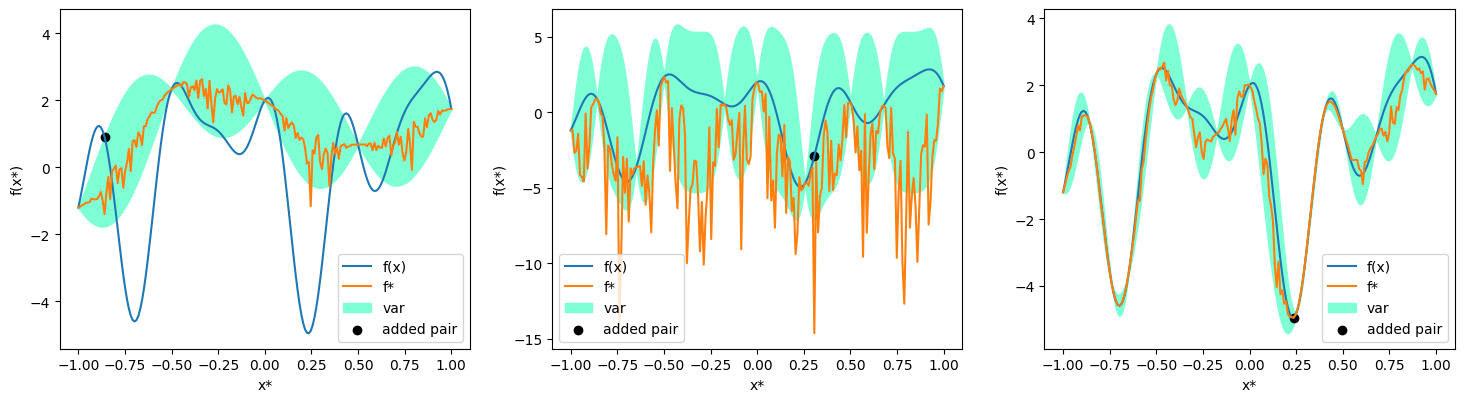

In [74]:
# times = 2
X = torch.tensor([-1, -1/2, 0, 1/2, 1])
y = func(X)
Xnew = torch.linspace(-1,1,200)
T = 10

X, y, f_loc_list, f_cov_list, f_list = Bayesian_Optimization_modified(X, y, Xnew)
plot()